# Find Path Descriptors using Z space of Autoencoder

Autoencoder are good at:
- **dimensionality reduction** for data visualization
- **data denoising** for robust feature learning

Dimensions of Input space= n x 100 x 3
Dimensions of Latent space (z-space)= z

# Enhance reproducability of results

In [1]:
#%env PYTHONHASHSEED=0 
#%env CUDA_VISIBLE_DEVICES=""

In [2]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(0)
random.seed(0)
tf.set_random_seed(0)

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
def resetRNG(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.set_random_seed(seed_value)

# Import .npz Database containing 5SS mechanisms and cplr paths

In [4]:
import os

current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','norm_database5SS.npz')

In [5]:
db = np.load(db_path)
db.files
cplr=db['cplrData']
mech=db['mechData']

print(cplr.shape)
print(mech.shape)

(1453, 100, 3)
(1453, 11, 3)


In [6]:
# Plotting Functions

#%matplotlib inline
%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import interpolate


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

# Splitting the database in Train/Test dataset

In [7]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=1)

In [8]:
from keras.layers import Input, Dense, Flatten, Reshape, SeparableConv1D, concatenate
from keras.models import Model
from keras.layers import LeakyReLU
from keras import regularizers
#from keras import initializers
import keras

def testAutoEncoder(autoencoder, encoder, x_train, x_test, epochs=50):
    # TRAINING PHASE
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=128, 
                                      shuffle=False, validation_data=(x_test, x_test), verbose=0)
    loss = autoencoder_train.history['loss']
    val_loss = autoencoder_train.history['val_loss']
    print('Final Training loss: '+str(np.round_(loss[-1],decimals=4)))
    print('Final Validation loss: '+str(np.round_(val_loss[-1],decimals=4)))
    epochsRange = range(epochs)
    plt.figure()
    plt.plot(epochsRange, loss, 'r', label='Training loss')
    plt.plot(epochsRange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    # VISUALIZING RESULTS
    predicted_curve = autoencoder.predict(x_test)
    z_param = encoder.predict(x_test)
    #print(z_param)
    #print(predicted_curve)

    n = 20  # how many digits we will display
    plt.figure(figsize=(3*n, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1, projection='3d')

        # Fit cubic B-spline to the predicted points
        xp=predicted_curve[i,:,0]
        yp=predicted_curve[i,:,1]
        zp=predicted_curve[i,:,2]
        
        # Check for duplicate points as interpolation routine errors out
        okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
        xp = np.r_[xp[okay], xp[-1]]
        yp = np.r_[yp[okay], yp[-1]]
        zp = np.r_[zp[okay], zp[-1]]
    
        tck, u =interpolate.splprep([xp,yp,zp],s=1)
        num_pts=100
        u_fine = np.linspace(0,1,num_pts)
        x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
        Path_100 = np.vstack(([x_100],[y_100],[z_100])).T

        # display reconstruction
        plotPath(Path_100, ax, 2,'r' )
        # display original
        plotPath(x_test[i], ax, 2)

    plt.tight_layout()
    plt.show()

# Perform Hierarchical Clustering (K-Mean)(also try Dendrogram)

C:\Users\sshel\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


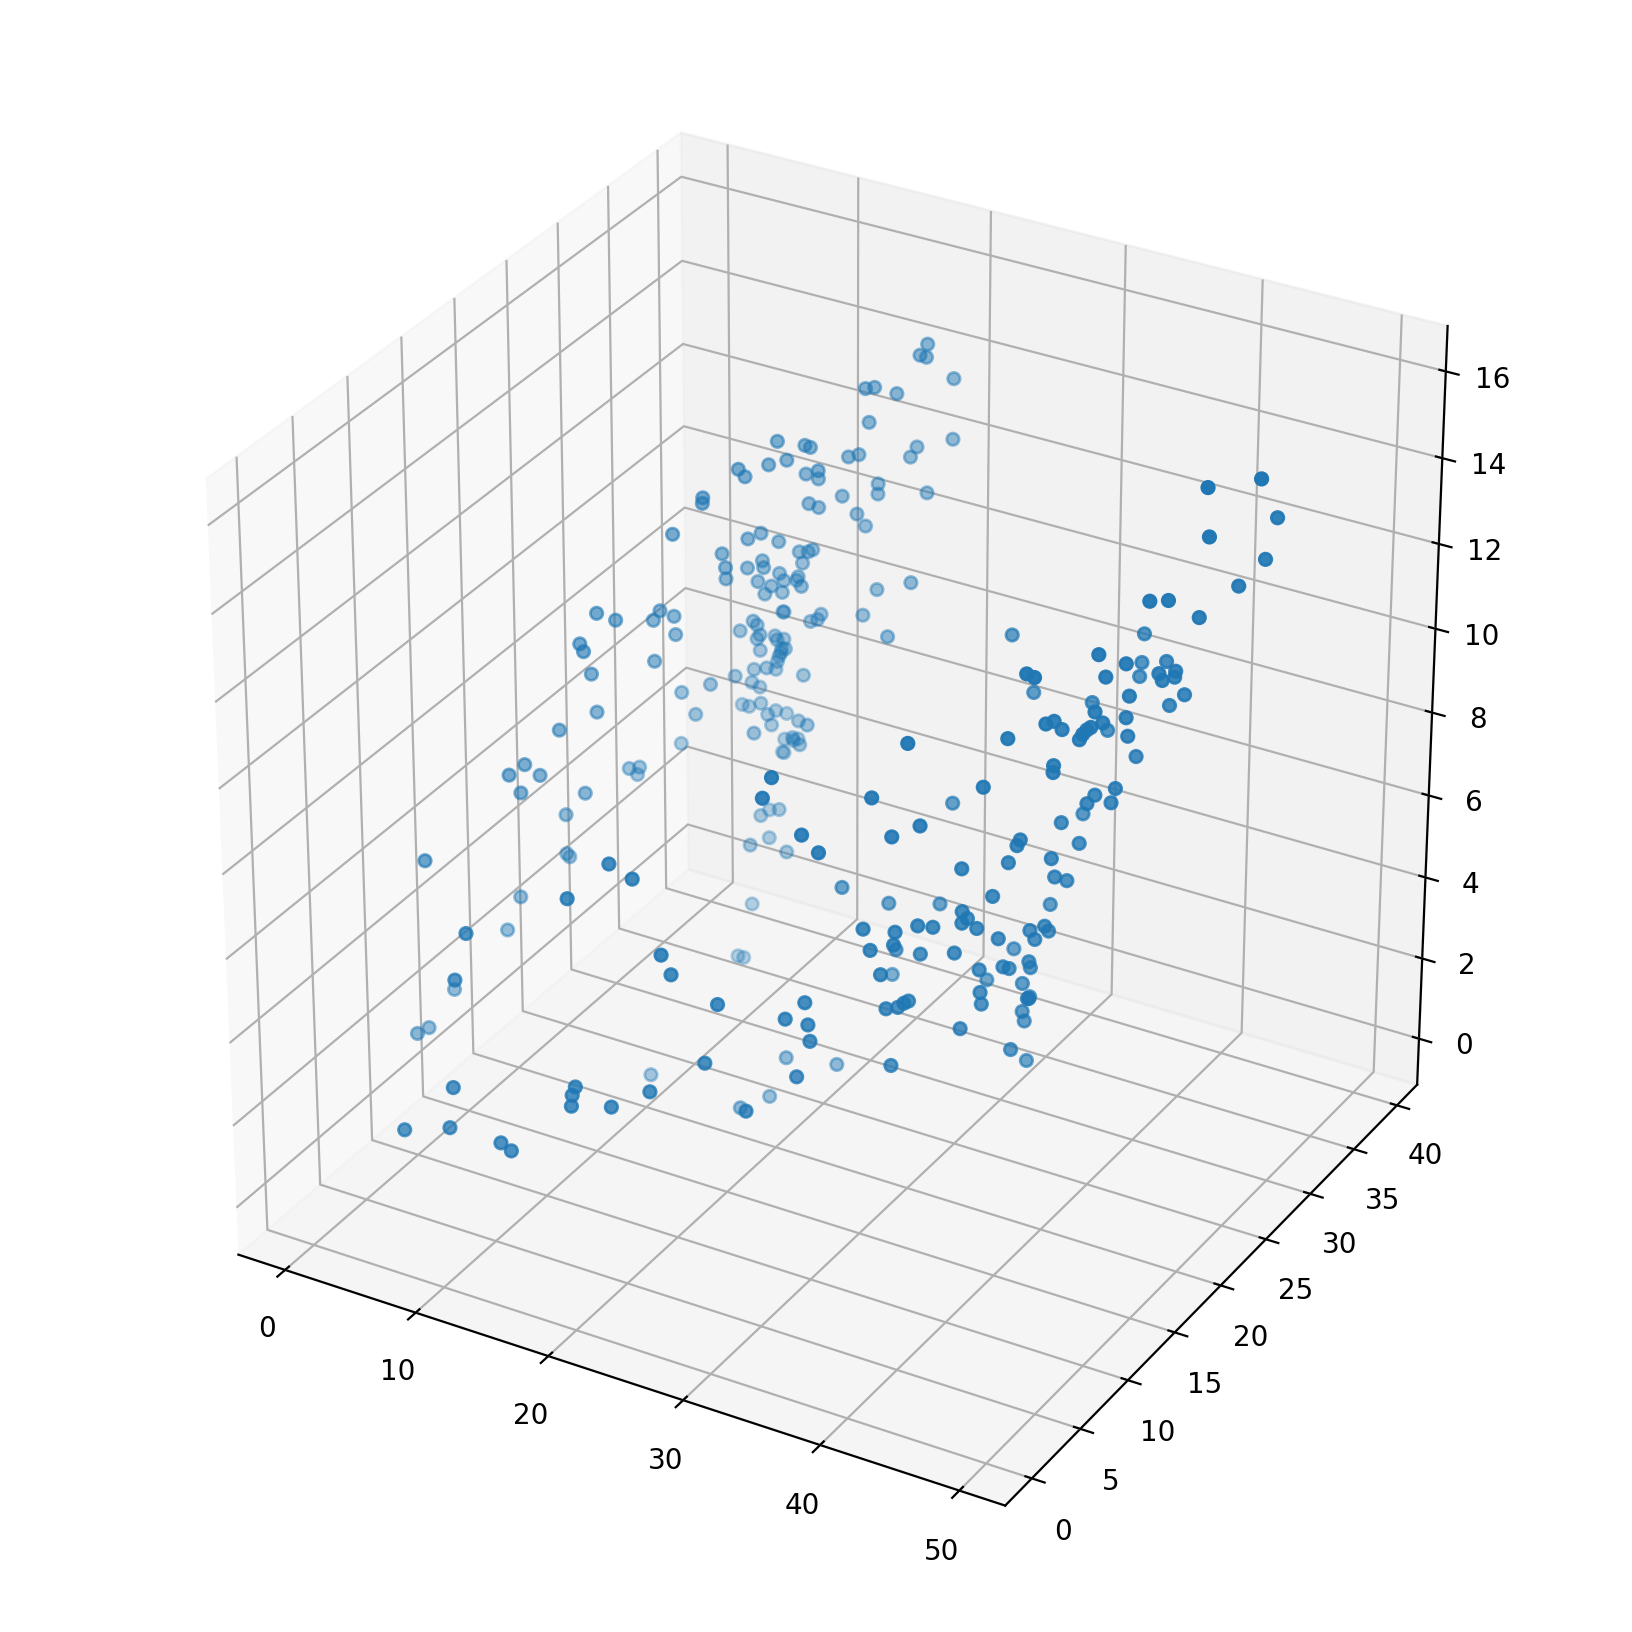

In [20]:
z_param = encoderZ3.predict(x_test)
#print(z_param)

fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:,0],z_param[:,1],z_param[:,2])

plt.tight_layout()
plt.show()

In [21]:
from sklearn.cluster import KMeans

C:\Users\sshel\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


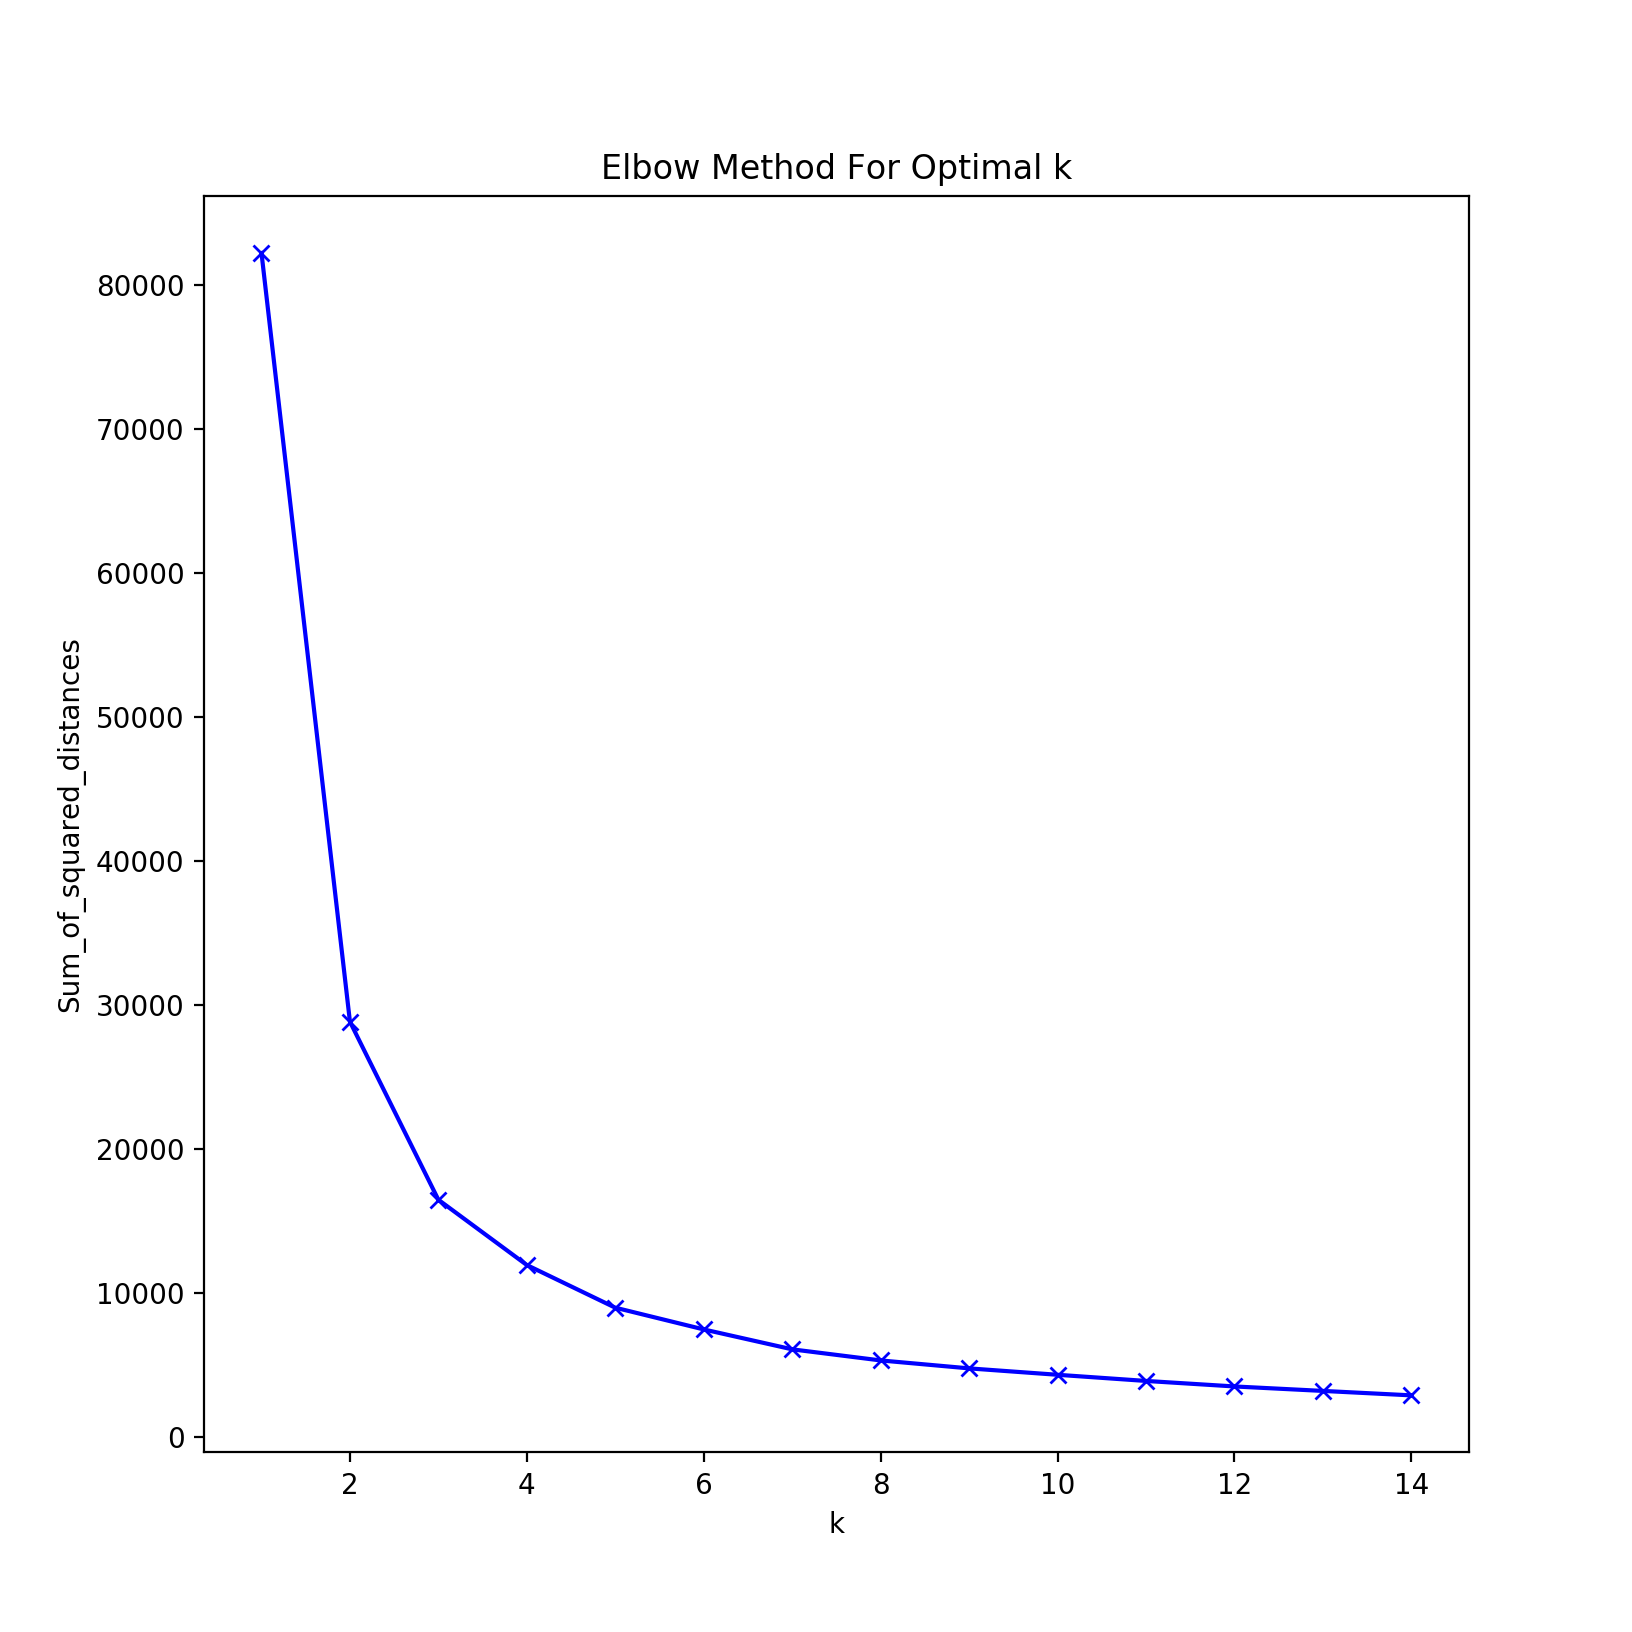

In [22]:
#Find optimal K-value using the elbow method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(z_param)
    Sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\sshel\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


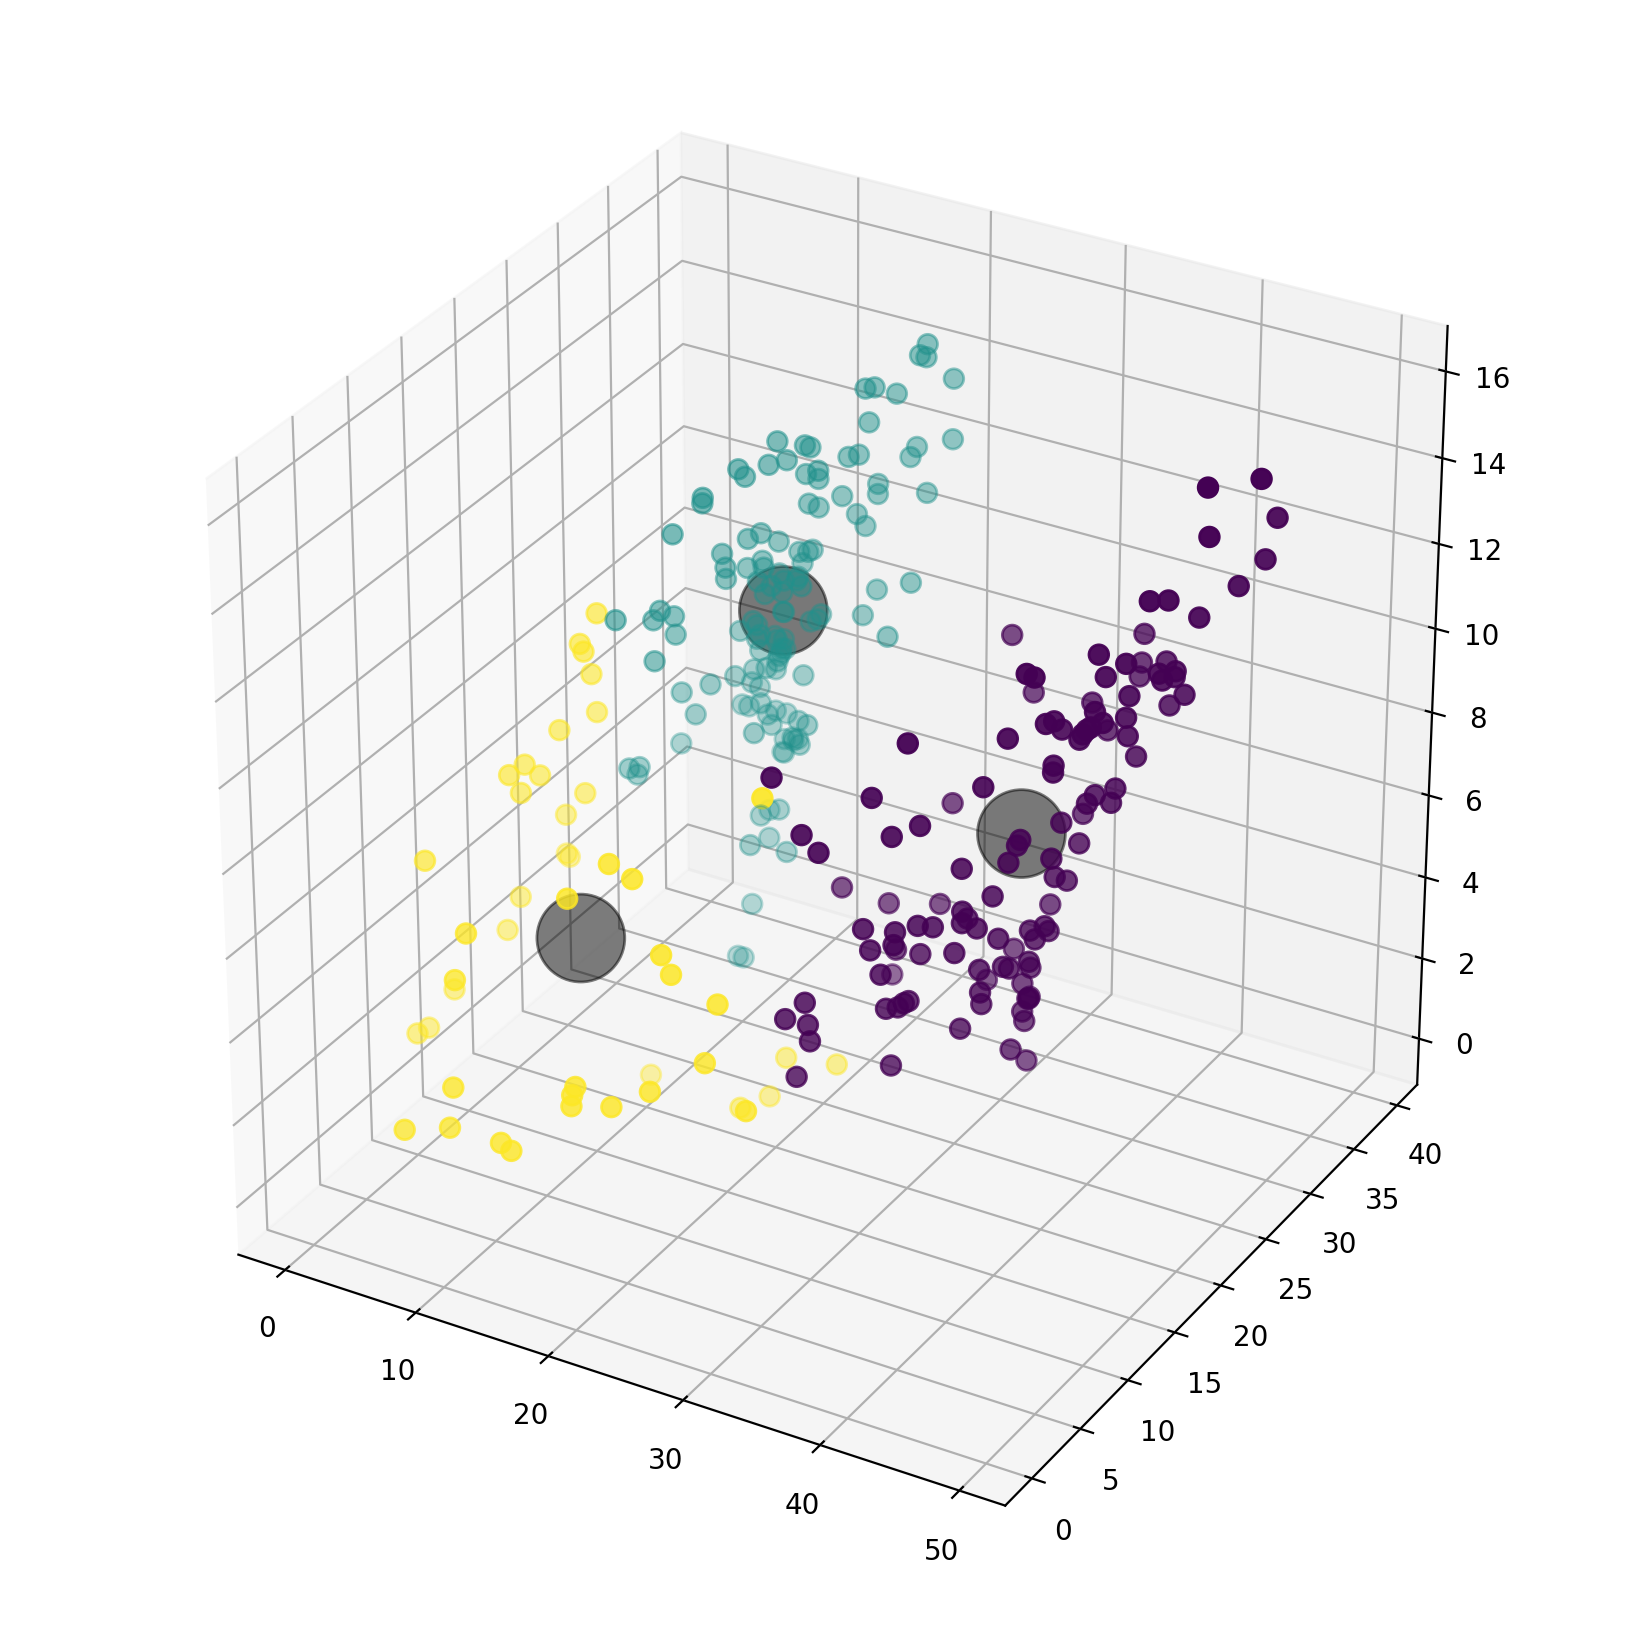

In [23]:
optK=3
kmeans = KMeans(n_clusters=optK)
kmeans.fit(z_param)
y_kmeans = kmeans.predict(z_param)

centers = kmeans.cluster_centers_
fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:, 0], z_param[:, 1], z_param[:, 2], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=1000, alpha=0.5);

plt.tight_layout()

# Find similar paths using KNN on Cluster Centers